<a href="https://colab.research.google.com/github/yuanfeiwo/test-firstrepository/blob/master/Module5_5_3_Hyper_parameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Module: Data Science in Finance, Machine Learning in 30 minutes!
# Version 2.0
# Topic : Hyperparameter Tuning
# Example source: https://www.kaggle.com/wendykan/lending-club-loan-data
#####################################################################
# For support or questions, contact QuantUniversity at
# info@qusandbox.com
# Copyright 2020 QuantUniversity LLC.
#####################################################################

# Hyperparameter Tuning

This notebook deals with understanding the lending data obtained from https://www.kaggle.com/wendykan/lending-club-loan-data. We will cluster the data using K-Means clustering to see patterns in the dataset.

# Contents

* Imports
* Exploring the data
    * Dataset
    * Numerical and Categorical Features
* Preparing the data
    * Normalizing the data
    * Randomizing the data
    * Train-Test split
* Neural Networks
    * Layers, weights, backpropagation
* Hyperparameters vs parameters
    * Learning Rate
        * Learning curve
    * Optimization algorithm
    * Regularization, alpha
    * Activation Funciton
* Grid Search


## Imports

In [2]:
# for numerical analysis and data processing
import numpy as np
import pandas as pd
import itertools

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# for Machine learning algorithms
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cdist

# for vizualizations
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import requests
from io import StringIO

# Exploring the Data

## Dataset

The data set is the lending data for lendingclub from August 2011 to December 2011 for some borrowers. The feature descriptions for the data are also provided. Not all the features are required for making predictions, some features are redundant in the original data file. The provided data file is already cleaned and only relevant features are provided. There are two types of features, numerical and categorical.

Reading the input data from csv file.

In [3]:
orig_url_data='https://drive.google.com//file//d//1yG-JxC1Br3c8u3cfmKQWC9pgz6Pqggw5//view?usp=sharing'
file_id = orig_url_data.split('//')[-2]
dwn_url='https://drive.google.com//uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)

orig_url_description='https://drive.google.com//file//d//1HFd4gKbknC28rHTWysec48NqfB6g3ZHx//view?usp=sharing'
file_id = orig_url_description.split('//')[-2]
dwn_url='https://drive.google.com//uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df_description = pd.read_excel(dwn_url)


del df['issue_d'] # removing issue date as it wont affect the prediction (redundant feature)

## Numerical and Categorical features

In [4]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df[col] = df[col].astype('category')

In [5]:
numeric_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'loan_status_Binary'],
      dtype='object')

In [6]:
categorical_columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'addr_state'],
      dtype='object')

#### Dictionary for categorical features.

In [7]:
categories={}
for cat in categorical_columns:
    categories[cat] = df[cat].cat.categories.tolist()

In [8]:
p_categories = df['purpose'].cat.categories.tolist()
s_categories = df['addr_state'].cat.categories.tolist()
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

Storing interest rate statistics which will be used later for inference. 

In [9]:
min_rate= df['int_rate'].min()
max_rate= df['int_rate'].max()
print(min_rate, max_rate, max_rate- min_rate)

5.42 24.11 18.689999999999998


## Preparing the dataset 

#### Normalizing the data
Normalize the data set for ease of calculations so that all features have values between 0 and 1.

In [10]:
df_max = df.max()
df_min = df.min()

In [11]:
df=(df-df.min())/(df.max()-df.min())

#### Randomizing the data
Randomize the dataset so that any ordered patterns dont influence the prediction. (We have already skipped date as an influencing factor)

In [12]:
df = df.iloc[np.random.permutation(len(df))]

#### Train-test split
The data is split into training and testing data. x represents the input features whereas y represents the output i.e. the interest rate.As a rule of thumb, we split the data into 80% training data and 20% testing or validation data.

In [13]:
y = df.iloc[:,df.columns.isin(["int_rate"])]
x = df.loc[:, ~df.columns.isin(["int_rate"])]

total_samples=len(df)
split = 0.8

x_train = x[0:int(total_samples*split)]
x_test = x[int(total_samples*split):total_samples]
y_train = y[0:int(total_samples*split)]
y_test = y[int(total_samples*split):total_samples]

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    Calculates mean absolute error of the true and predicted values.
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    count = 0
    sum = 0
    for a, p in zip(y_true, y_pred):
        if(a!=0):
            sum+=(abs(a-p)/a)
            count+=1
    return (sum/count) * 100

In [15]:
def view_metrics(y_test, predictions, algorithm, samples, total_samples):
    '''
    Plots the true and predicted values and prints RMS, MAE and MAPE metrics.
    '''
    fig = plt.figure(figsize=(18,5))
    plt.scatter(x=[i for i in range(samples)], y=[x for x in predictions[0:samples]], label='Predicted values')
    plt.scatter(x=[i for i in range(samples)], y=[x[0] for x in y_test.values[0:samples]], label='True values')
    plt.title('True and Predicted values for test dataset - %s' % algorithm)
    plt.legend()
    plt.show()
    
#     fig = plt.figure(figsize=(18,5))
#     plt.scatter(x=[i for i in range(total_samples)], y=[x for x in predictions], label='Predicted values')
#     plt.scatter(x=[i for i in range(total_samples)], y=[x[0] for x in y_test.values], label='True values')
#     plt.title('True and Predicted values for test dataset - %s' % algorithm)
#     plt.legend()
#     plt.show()

    RMS =  np.sqrt(mean_squared_error(y_test, predictions, multioutput='raw_values'))
    MAE = mean_absolute_error(y_test, predictions, multioutput='raw_values')
    MAPE = mean_absolute_percentage_error(y_test, predictions)
    print("Root Mean Squared Error:", RMS)
    print("Mean Absolute Error", MAE) 
    print("Mean Absolute Percentage Error", MAPE)
    return RMS, MAE, MAPE

In [16]:
def view_metrics2(y_true, predictions, algorithm, samples, total_samples):
    '''
    Plots the true and predicted values and prints RMS, MAE and MAPE metrics.
    '''    
    plt.scatter(x=[x for x in predictions[0:samples]], y=[x[0] for x in y_true.values[0:samples]])
    plt.title('True vs Predicted values- %s' % algorithm)
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    plt.show()

    RMS =  np.sqrt(mean_squared_error(y_true, predictions, multioutput='raw_values'))
    MAE = mean_absolute_error(y_true, predictions, multioutput='raw_values')
    MAPE = mean_absolute_percentage_error(y_true, predictions)
    print("Root Mean Squared Error:", RMS)
    print("Mean Absolute Error", MAE) 
    print("Mean Absolute Percentage Error", MAPE)
    return RMS, MAE, MAPE

# Machine Learning Models

## Neural Network Regression Model

The entire neural network can be considered as a non linear mathematical function with many parameters, which are called weights of the neural network. The features are the inputs of the neural network. The circles here represent neurons in the neural network, each with its own weights (coefficients).

![alt text](https://docs.google.com/uc?export=download&id=12rVcD1thH1D-N2Uw7RbwGUfpXNmqcya0)


### Layers, Weights, and Backpropagation in Neural Networks

For our data set, the number of features are 16. Each layer between the input layer (where we enter the dataset) and output layer (where we obtain our predicted value) is called as a hidden layer of the neural network. Usually, but not always, higher number of layers tend to capture more nuances in the data and fit the training data better.

When we pass in the labels(y) and the features(X) to a training model, the weights in these layers act as coefficients and multiply the value of the feature and ultimately gives out a single value (can be multi-dimensional output as well) at the output layer.

This value is checked against the actual value or label that we pass, the difference in the actual and predicted value gives us a loss. This loss is then distributed back in all the layers to accommodate  for it. This is done using various algorithms, most prominently **back propagation algorithm**. The rate at which these changes occur can be regarded as learning rate.

For our initial  model, the learning rate was selected to be 0.001. The number of iterations, 300 in our case, specify for how many iterations should the forward pass and the backpropagation process continue. There are 10 neurons in the first hidden layer and 4 in the next.

#### Neural networks have a lot of hyperparameters that show their immediate effects on the learning curve, so we will choose this as a means to study hyperparameters.

## Hyperparameters vs Parameters

As discussed above, parameters of a neural network are the weights associated with the neurons that are actually involved in the calculations. Hyperparameters on the other hand are factors that determine how the model will be trained, like the number of iterations, the algorithms to be used, penalties to be applied and so on.

### Hyperparameter tuning - Learning Rate
We will try to run the training for different values of the learning rate and see the changes. Based on the lowest loss, we will select the learning rate.

In [17]:
import warnings
warnings.filterwarnings('ignore')

def tune_learning_rate(learning_rates):
    models = []
    i=0
    for lr in learning_rates:
        nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                            activation='relu', # activation function in the neurons of the neural net
                                            solver='adam', # optimizer algorithm
                                            learning_rate='constant',
                                            learning_rate_init=lr, # initial learning rate
                                            max_iter=300, # max iterations to train for
                                            tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                            shuffle=True,
                                            random_state = 3,
                                            verbose=False) # show details at each iteration
        nn_model = nn_model.fit(x_train, y_train.values.ravel())
        models.append(nn_model)
        print("Model",i,",For learning rate %s, loss is %.5f" % (lr, nn_model.loss_))
        i = i+1;
    return models

In [18]:
# this cell may take a few seconds to run
learning_rates = np.array([0.00001, 0.0001, 0.001, 0.1, 0.5, 1])
models = tune_learning_rate(learning_rates)

Model 0 ,For learning rate 1e-05, loss is 0.01781
Model 1 ,For learning rate 0.0001, loss is 0.00030
Model 2 ,For learning rate 0.001, loss is 0.00013
Model 3 ,For learning rate 0.1, loss is 0.02605
Model 4 ,For learning rate 0.5, loss is 0.02777
Model 5 ,For learning rate 1.0, loss is 0.03003


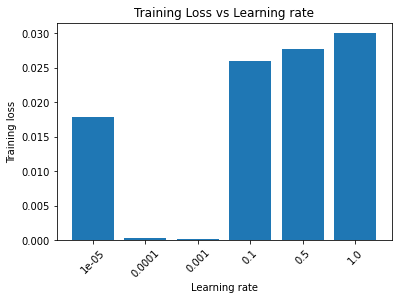

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.bar(x=range(len(models)),height=[m.loss_ for m in models])
axes.set_title('Training Loss vs Learning rate')
axes.set_xlabel('Learning rate')
axes.set_ylabel('Training loss')
axes.set_xticks(np.arange(len(learning_rates)))
axes.set_xticklabels(learning_rates, rotation = 45)
plt.show()

### Learning rate: 0.00001

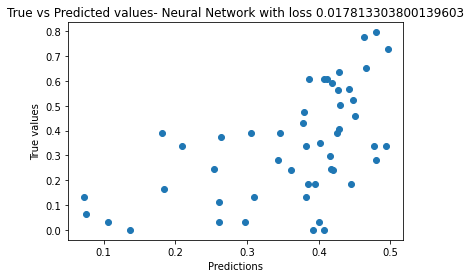

Root Mean Squared Error: [0.18854411]
Mean Absolute Error [0.15338526]
Mean Absolute Percentage Error [105.36649549]


(array([0.18854411]), array([0.15338526]), array([105.36649549]))

In [20]:
view_metrics2(y_train, models[0].predict(x_train),'Neural Network with loss '+str(models[0].loss_), samples = 50, total_samples=2000)

#### The graph of true values vs predictions show no trends at all. This means that the predicted values are nowhere related to the true values. For a really low learning rate, there wasn't any considerable learning in 300 iterations.

### Learning rate: 0.001

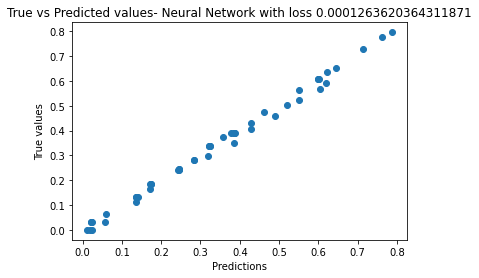

Root Mean Squared Error: [0.01555514]
Mean Absolute Error [0.01229864]
Mean Absolute Percentage Error [6.50397874]


(array([0.01555514]), array([0.01229864]), array([6.50397874]))

In [21]:
view_metrics2(y_train, models[2].predict(x_train),'Neural Network with loss '+str(models[2].loss_), samples = 50, total_samples=2000)

#### The graph of true values vs predictions lie on a line at around 45 degrees. This means that the predicted values are almost same as the true values. Had they been identical, we would have seen a single line at 45 degree. For a learning rate of 0.001 the loss is considerably low.

### Learning rate: 0.05

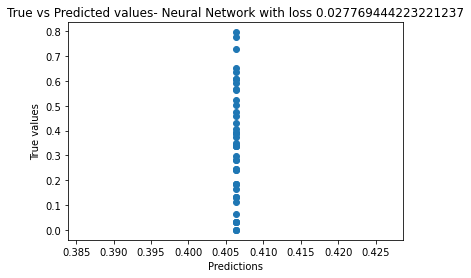

Root Mean Squared Error: [0.22855157]
Mean Absolute Error [0.18925724]
Mean Absolute Percentage Error [141.91643898]


(array([0.22855157]), array([0.18925724]), array([141.91643898]))

In [22]:
view_metrics2(y_train, models[4].predict(x_train),'Neural Network with loss '+str(models[4].loss_), samples = 50, total_samples=2000)

#### The graph of true values vs predictions lie on a straight vertical line. This means that the model just predicted a single value for all inputs. This is a result of very very high learning rate of 0.5.

### Learning Curve
It is a plot of the model loss against any unit of time. In this case we plot loss vs number of iterations

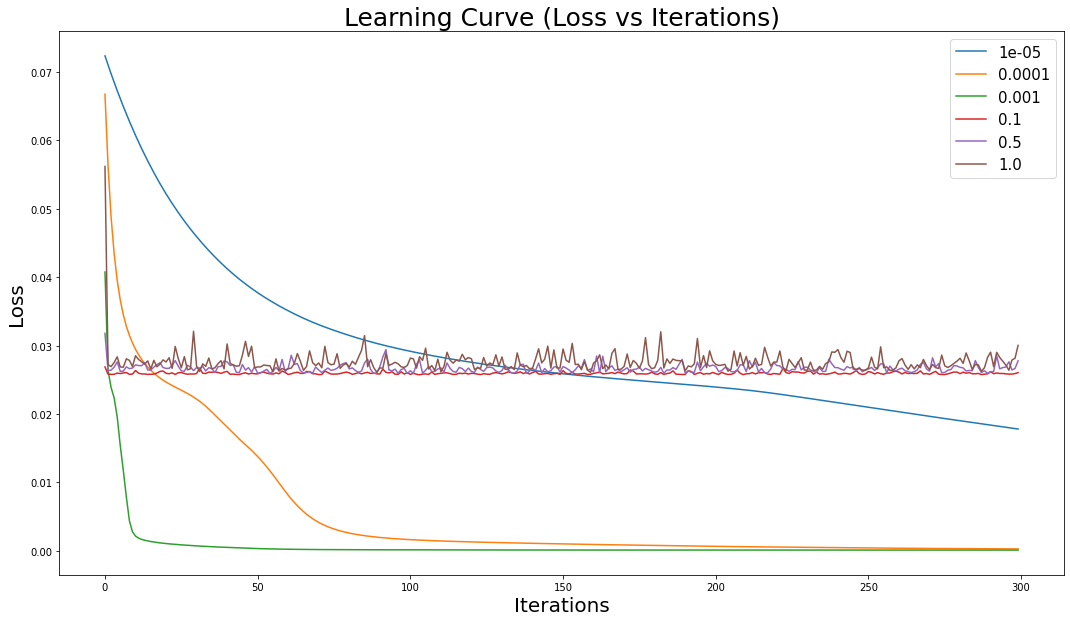

In [23]:
fig = plt.figure(figsize=(18,10))
for model in models:
    plt.plot(model.loss_curve_[:])
    plt.legend(learning_rates[:], fontsize=15)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Learning Curve (Loss vs Iterations)', fontsize=25)
plt.show()

#### Convergence refers to a state when the losses do not vary much within a given tolerance and drop down to low values.

#### We can see that high learning rates show practically no learning from the model. Really low learning rate tend to converge very slowly. The optimal value converges really quickly. The lowest learning rate could have give better results had we allowed it to run for many more iterations.

### Hyperparameter tuning - Optimization algorithm
Now that we have selected the learning rate that yields lowest loss, let us see what effect does the optimization algorithm have on the model.

In [24]:
optimizers = ['adam', 'sgd']

def select_optimizer(optimizers):
    models = []
    i=0
    for opt in optimizers:
        nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                            activation='relu', # activation function in the neurons of the neural net
                                            solver=opt, # optimizer algorithm
                                            learning_rate='constant',
                                            learning_rate_init=0.001, # initial learning rate
                                            max_iter=500, # max iterations to train for
                                            tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                            shuffle=True,
                                            random_state = 3,
                                            verbose=False) # show details at each iteration
        nn_model = nn_model.fit(x_train, y_train.values.ravel())
        models.append(nn_model)
        print("Model",i,",For optimizer %s, loss is %.5f" % (opt, nn_model.loss_))
        i = i+1;
    return models

In [25]:
models = select_optimizer(optimizers)

Model 0 ,For optimizer adam, loss is 0.00013
Model 1 ,For optimizer sgd, loss is 0.00142


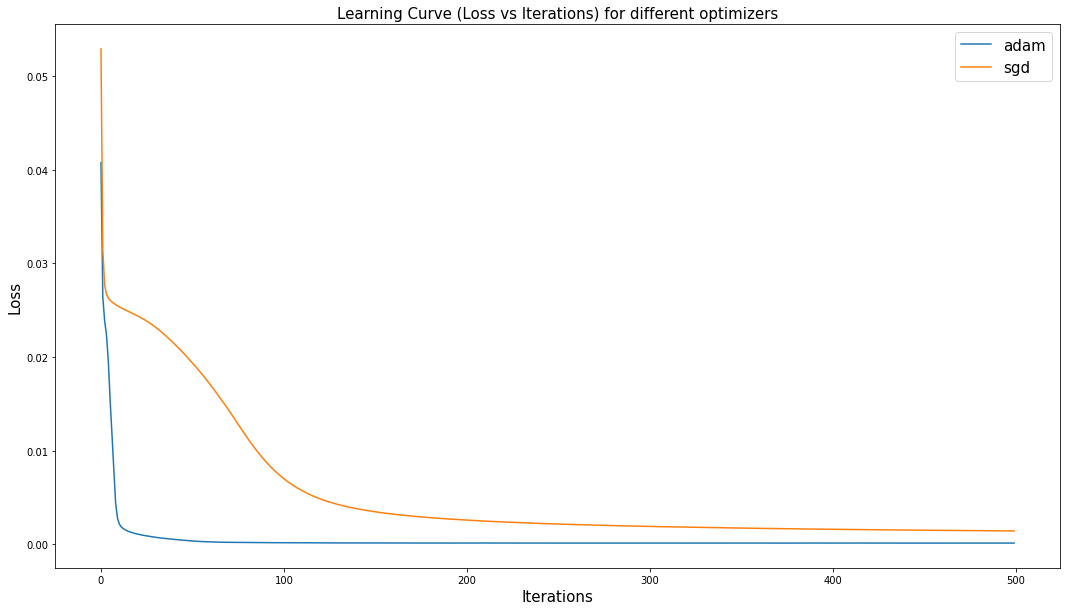

In [26]:
fig = plt.figure(figsize=(18,10))
for model in models:
    plt.plot(model.loss_curve_)
    plt.legend(optimizers, fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Learning Curve (Loss vs Iterations) for different optimizers', fontsize=15)
plt.show()

#### SGD or Stochastic Gradient Descent and Adam and Adam are two  of the three popular optimization algorithms provided by the scikit-learn package. The third one is called 'lbfgs', another from a quasi-Newton method. It is suitable for really small datasets and doesnt provide a good learning curve.

### Hyperparameter tuning - Regularization parameter
**Regularization basically adds a penalty as model complexity increases. Regularization parameter (L2 alpha) penalizes all the parameters except intercept so that model generalizes the data and won’t overfit and the paramters arent updated as drastically.**

**Overfitting** refers to the fact that the model has fit the training data so well that it doesnt recognise outliers i.e. it has fit the noise in the training data as we. A more complex model usually tends to overfit. For example, a neural net with too many layers may fit to the training data very well but wont be able to generalize on testing or validation data set.

Overfitting causes the model to not accept new samples readily, i.e, it doesn't generalize well while making predictions.

Similarly there is **underfitting**, when the model is not able to provide a low loss even on the training data, let alone a testing dataset.

The first figure shows a sample of underfitting, the second one is a good fit and the third one is overfitting. A higher degree polynomial is more complex than a linear model in the first case, hence it overfits.

![alt text](https://docs.google.com/uc?export=download&id=1v6ElyEPb6UtzdxqSUPdfVmAIlzRCw_eb)

In [27]:
alphas = [0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]

def tune_alpha(alphas):
    models = []
    i=0
    for alpha in alphas:
        nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                            activation='relu', # activation function in the neurons of the neural net
                                            solver='adam', # optimizer algorithm
                                            learning_rate='constant',
                                            learning_rate_init=0.001, # initial learning rate
                                            max_iter=500, # max iterations to train for
                                            tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                            shuffle=True,
                                            random_state = 3,
                                            alpha = alpha,
                                            verbose=False) # show details at each iteration
        nn_model = nn_model.fit(x_train, y_train.values.ravel())
        models.append(nn_model)
        print("Model",i,",For alpha %s, loss is %.5f" % (alpha, nn_model.loss_))
        i = i+1;
    return models

In [28]:
models = tune_alpha(alphas)

Model 0 ,For alpha 0.5, loss is 0.00368
Model 1 ,For alpha 0.1, loss is 0.00099
Model 2 ,For alpha 0.01, loss is 0.00023
Model 3 ,For alpha 0.001, loss is 0.00016
Model 4 ,For alpha 0.0001, loss is 0.00013
Model 5 ,For alpha 1e-05, loss is 0.00013


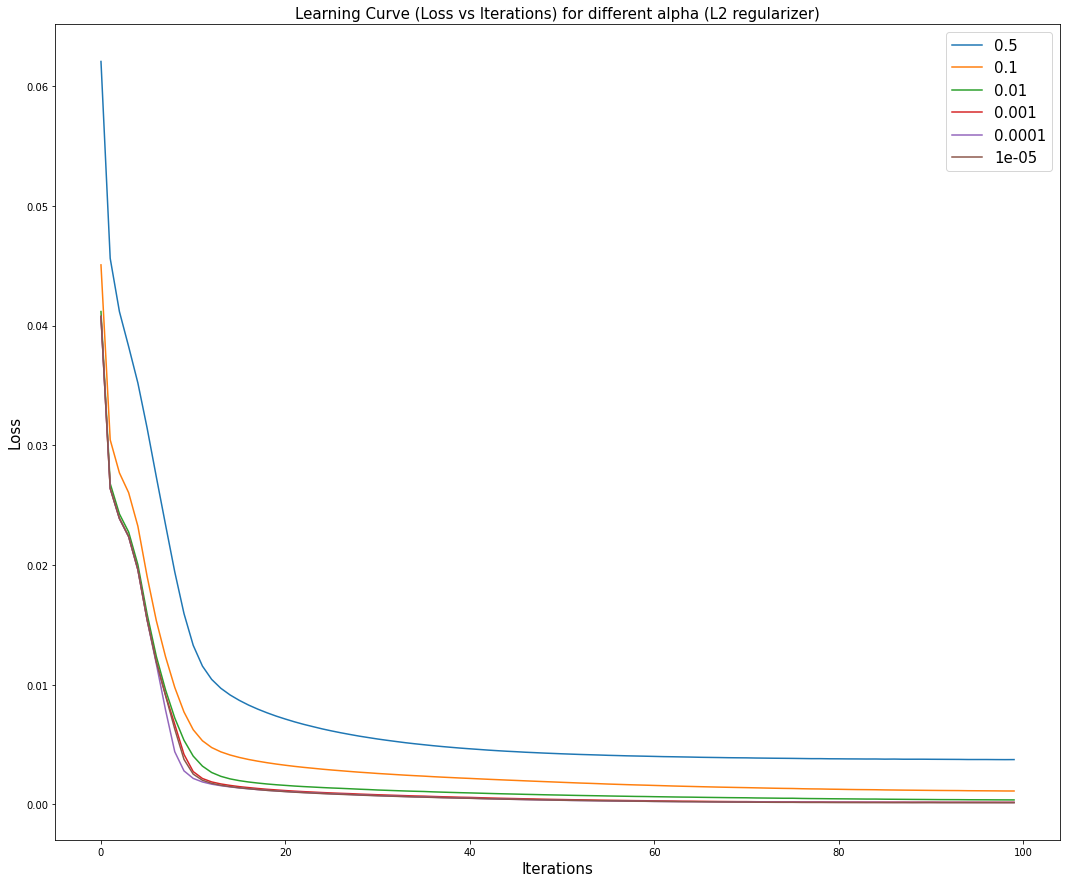

In [29]:
fig = plt.figure(figsize=(18,15))
for model in models:
    plt.plot(model.loss_curve_[0:100])
    plt.legend(alphas,fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Learning Curve (Loss vs Iterations) for different alpha (L2 regularizer)', fontsize=15)
plt.show()

#### High L2 penalty causes underfitting as it doesn't allow the model to train. So the L2 alpha values have to be low.

## Activation function

Activation functions are functions that introduce non linearities in the neural network. If we do not apply any non linearliy, our entire network would be just one big linear function, only transforming the input from one layer to another.

A Neural Network without Activation function would simply be a Linear regression Model, which has limited power as we already saw in the last lab. We want our Neural Network to not just learn and compute a linear function but something more complicated than that.

ReLU or Rectified Linear Unit is the activation function we are using.  
Mathematically: **A(x) = max(0,x)**

## Grid Search

We saw the individual effect of each of the hyperparameters in a neural network. Now we will perform a Grid Search. A Grid Search is essentially a exhaustive search on a predefined set of hyperparemters were all possible combinations of the hyperparamters are tried out. In for the below configurations, the grid search will perform 64 fit operations, 32 combinations with 2 fold cross validation.

In [30]:
from sklearn.model_selection import GridSearchCV
nn_cv = MLPRegressor(hidden_layer_sizes=(10,4))
parameters = {'activation':['tanh', 'relu'], 
              'solver':['sgd', 'adam'],
              'alpha':[0.001,  0.00001],
              'max_iter':[300,500],
              'learning_rate_init':[0.00001, 0.001]
              }
reg = GridSearchCV(nn_cv, parameters, cv=2, verbose = True)

In [31]:
# This cell will take a few minutes to run
reg.fit(x_train, y_train.values.ravel())

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  1.6min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(10, 4),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=...ffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['t

The GridSearchCV function is useful to reduce the amount of code. The individual hyperparameter selection that we did earlier can all be done using this simple function. We can see that the GridSearch also provided the same model as we selected manually.

In [32]:
reg.best_estimator_

MLPRegressor(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# Finalizing our model

#### The configuration of the neural netowrk is referred to as its architecture . The architecutre for our network is as follows:
| -   |      -      |
|----------|-------------|
| Input dimension |  16 |
| Output dimension |  1 |
| Hidden Layers |    2   |
| Neurons in Hidden Layer 1 | 10 |
| Neurons in Hidden Layer 2 | 4 |
| Optimier | Adam |
| Activation Function | ReLU |
| Learning rate | 0.001 |
| L2 Regularizer | 0.0001 |


Now that we have tuned certain hyperparameters, let us go ahead a nd train the model for one last time.

In [33]:
nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                            activation='relu', # activation function in the neurons of the neural net
                                            solver='adam', # optimizer algorithm
                                            learning_rate='constant',
                                            learning_rate_init=0.001, # initial learning rate
                                            max_iter=500, # max iterations to train for
                                            tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                            shuffle=True,
                                            random_state = 3,
                                            alpha = 0.0001,
                                            verbose=False) # show details at each iteration
nn_model = nn_model.fit(x_train, y_train.values.ravel())

In [34]:
nn_model_predictions = nn_model.predict(x_test)
nn_model_predictions_tr = nn_model.predict(x_train)

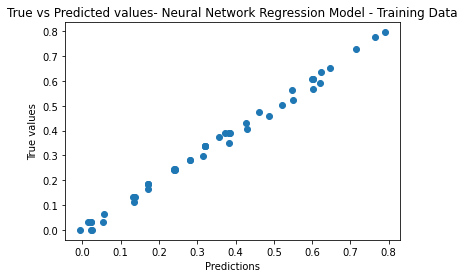

Root Mean Squared Error: [0.0156186]
Mean Absolute Error [0.01224882]
Mean Absolute Percentage Error [6.61922696]


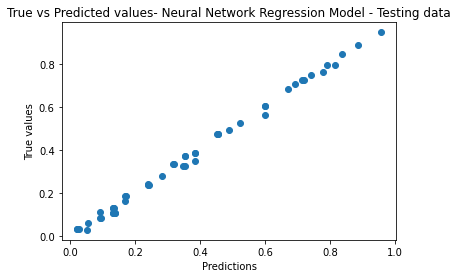

Root Mean Squared Error: [0.01530954]
Mean Absolute Error [0.01243063]
Mean Absolute Percentage Error [6.72720102]


In [35]:
nn_model_metrics_tr = view_metrics2(y_train, nn_model_predictions_tr,'Neural Network Regression Model - Training Data', samples = 50, total_samples=2000)
nn_model_metrics = view_metrics2(y_test, nn_model_predictions,'Neural Network Regression Model - Testing data', samples = 50, total_samples=2000)

#### If the MAPE for testing data is more then that for the training data, and this is fine. This indicates that the model hasnt overfit. Had it overfit, the MAPE would have been lesser for the test data and more for training data.

If there is overfitting, we can play around with the alpha values and learning rate to get rid of overfitting.

### Exporting the model

In [36]:
# this cell may take a few seconds to execute depending on model size

# for saving models
import pickle
# import _pickle as cPickle # try this if previous import fails

pickle.dump(nn_model, open('nn_model.model', 'wb'))

## Tuning Random forest regressor

We will now try to experiment with different depths for a random forest, depth being one of the important hyperparameter.

**We avoid very deep trees as they tend to overfit the data.**  
**For very low depths, there is underfitting and the data points are evidently not on a diagonal line.**  
**We can see that after depth 6, there isn't much change in the accuracy or the True vs Predicted plot.**  


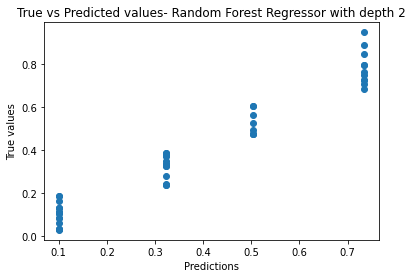

Root Mean Squared Error: [0.05925541]
Mean Absolute Error [0.04936679]
Mean Absolute Percentage Error [27.9937682]


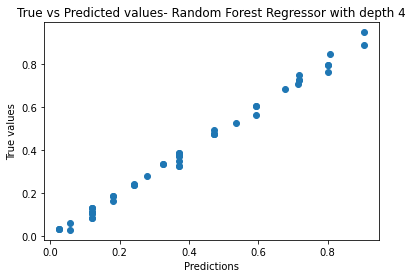

Root Mean Squared Error: [0.01737268]
Mean Absolute Error [0.01298577]
Mean Absolute Percentage Error [6.18193734]


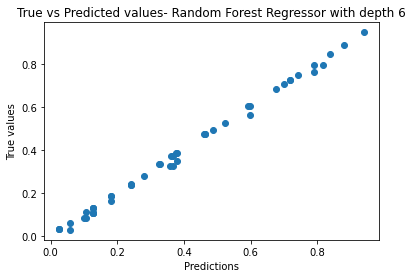

Root Mean Squared Error: [0.01430476]
Mean Absolute Error [0.01125909]
Mean Absolute Percentage Error [5.49254339]


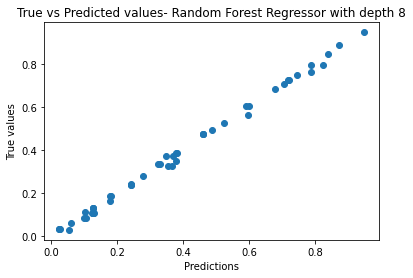

Root Mean Squared Error: [0.01431066]
Mean Absolute Error [0.01109009]
Mean Absolute Percentage Error [5.39471824]


In [37]:
depths = [2, 4, 6, 8]
for d in depths:
    rand_forest_model = RandomForestRegressor(max_depth=d, random_state=0) # build model
    rand_forest_model = rand_forest_model.fit(x_train, y_train.values.ravel()) # train model
    feature_importance = rand_forest_model.feature_importances_
    R2 = rand_forest_model.score(x_train, y_train) # coefficient of determination
    rand_forest_model_predictions = rand_forest_model.predict(x_test) # make predictions
    rand_forest_model_metrics = view_metrics2(y_test, rand_forest_model_predictions,'Random Forest Regressor with depth '+str(d), samples = 50, total_samples=2000)

In [38]:
# this cell may take a few seconds to execute depending on model size

rand_forest_model = RandomForestRegressor(max_depth=5, random_state=0) # build model
rand_forest_model = rand_forest_model.fit(x_train, y_train.values.ravel()) # train model

# for saving models
import pickle
# import _pickle as cPickle # try this if previous import fails

pickle.dump(rand_forest_model, open('rand_forest.model', 'wb'))

## Tuning Linear Regression

Since 'delinq_2yrs','inq_last_6mths','loan_status_Binary' have very low correlation to the interest rate (as evident from the correlation metrix), we will try to train the linear regression model excluding these 4 features.

![alt text](https://docs.google.com/uc?export=download&id=1POUPW7dZXPCEB9Ios9fHYK8ghyE699w3)

RFE

In [39]:
lin_reg_model = LinearRegression() # build model
lin_reg_model= lin_reg_model.fit(x_train, y_train) # train model


# for saving models
import pickle
# import _pickle as cPickle # try this if previous import fails

pickle.dump(lin_reg_model, open('lin_reg_model.model', 'wb'))

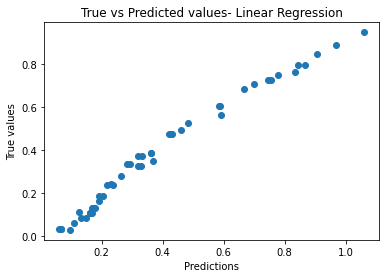

Root Mean Squared Error: [0.03712003]
Mean Absolute Error [0.03142306]
Mean Absolute Percentage Error [19.35404452]


In [40]:
lin_reg_model_predictions = lin_reg_model.predict(x_test) # make predictions
lin_reg_model_metrics = view_metrics2(y_test, lin_reg_model_predictions,'Linear Regression', samples = 50, total_samples=2000)

In [41]:
x_train_filtered = x_train.loc[:, ~x_train.columns.isin(['delinq_2yrs','inq_last_6mths','loan_status_Binary'])]
x_test_filtered = x_test.loc[:, ~x_test.columns.isin(['delinq_2yrs','inq_last_6mths','loan_status_Binary'])]

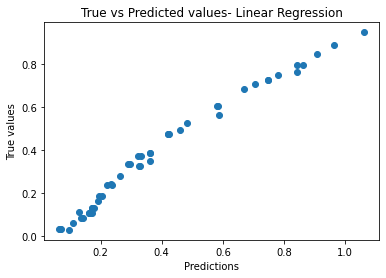

Root Mean Squared Error: [0.03741139]
Mean Absolute Error [0.03181324]
Mean Absolute Percentage Error [19.57314492]


In [42]:
lin_reg_model = LinearRegression() # build model
lin_reg_model= lin_reg_model.fit(x_train_filtered, y_train) # train model
lin_reg_model_predictions = lin_reg_model.predict(x_test_filtered) # make predictions
lin_reg_model_metrics = view_metrics2(y_test, lin_reg_model_predictions,'Linear Regression', samples = 50, total_samples=2000)

**Looking at both the above runs, we were right in our assumption that 'delinq_2yrs','inq_last_6mths','loan_status_Binary' arent as much related to the interest rate. The percentage error didnt change much**

## Saving data for prediction

In [43]:
# order is important
features = ["loan_amnt", "term", "installment", "grade", "sub_grade", "emp_length", "home_ownership", "annual_inc",
            "verification_status", "purpose", "addr_state", "dti", "delinq_2yrs", "inq_last_6mths", "loan_status_Binary"]

In [44]:
prediction_data = [rand_forest_model, df_max, df_min, categories, features]
pickle.dump(prediction_data, open('prediction_data.data', 'wb'))